

<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Homework #1 - Binary Choice 🐾</font>



# Instructions and submission guidelines
The goal of this homework is to introduce you to google colab notebooks and simple binary choice models, and implement evaluation methods which will be used in the first workshop next week.

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly and in reasonable time (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 24/11/2024, 23:59.
  * **Important note regarding due date**: The next workshop assumes you went through this exercise. Even if you submit the solution on Sunday evening, please go through the exercise before the workshop.
* For any questions regarding this homework task, contact [Eden](mailto:edens@campus.technion.ac.il).


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from tqdm.auto import tqdm

# Task #1: numpy + pandas syntax warm-up

Goal of this task is to make sure you are familiar with basic numpy and pandas syntax.



## numpy

Consider the following functions:

\begin{align}
f(x)
&=\begin{cases}
x & x \ge 0 \\
0 & x < 0
\end{cases}\\
g(x)
&=\begin{cases}
\sqrt{x} & x \ge 0 \\
-2(-x)^{\frac{1}{3}} & x < 0
\end{cases}
\end{align}

Implement $f(x)$, $g(x)$. Use vectorized numpy calculations, and avoid using loops.

The functions should accept a numpy array `x` as an argument.

🔵 **Answer**:

In [2]:
def f(x):
    ## YOUR SOLUTION
    return np.where(x >= 0, x, 0)


def g(x):
    ## YOUR SOLUTION
    return np.where(x >= 0, np.sqrt(x), -2 * (-x)**(1/3))


Plot $f(x),g(x)$ for $x\in[-1,1]$. Make sure the plot has an appropriate title, x/y labels, and a legend.

🔵 **Answer**:

<ipython-input-2-0d4fa9edfc0d>:8: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x >= 0, np.sqrt(x), -2 * (-x)**(1/3))
<ipython-input-2-0d4fa9edfc0d>:8: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, np.sqrt(x), -2 * (-x)**(1/3))


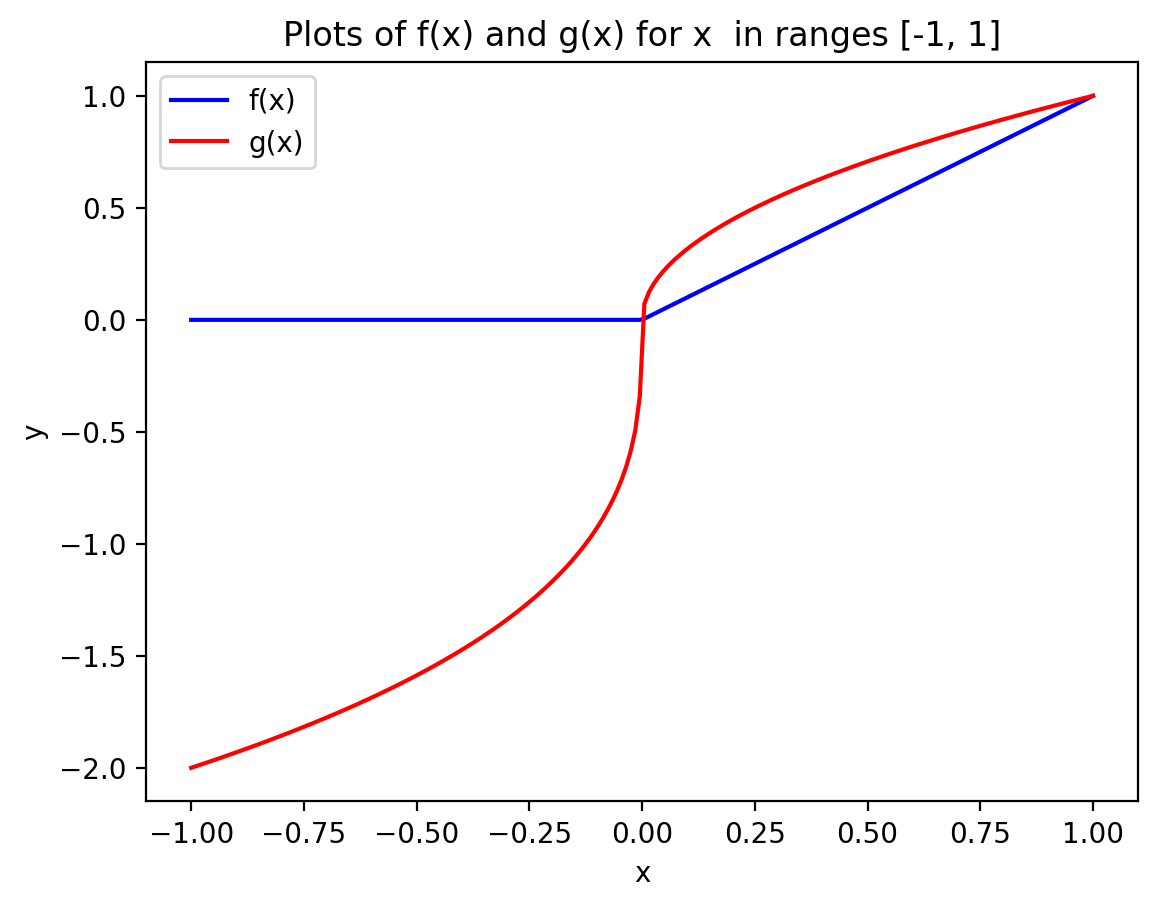

In [3]:
x = np.linspace(-1,1,200)
y1 = f(x)
y2 = g(x)

fig,ax = plt.subplots()

## YOUR SOLUTION
ax.plot(x, y1, label='f(x)', color='blue')
ax.plot(x, y2, label='g(x)', color='red')

ax.set_title("Plots of f(x) and g(x) for x  in ranges [-1, 1]")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

## pandas

To get ourselves familiar with the syntax, we use the classic [iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset:

In [4]:
from sklearn.datasets import load_iris
iris_df = load_iris(as_frame=True)['data']
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


How many rows in `iris_df` have `sepal_length>=6`?
Use vectorized calculations, and avoid using loops.

🔵 **Answer**:

In [8]:
## YOUR SOLUTION
relevant_rows = iris_df[iris_df['sepal length (cm)'] >= 6]
count = relevant_rows.shape[0] #rows
print(f"Number of rows with sepal_length >= 6: {count}")

Number of rows with sepal_length >= 6: 67


Plot a histogram of `sepal_width` with 20 bins:

🔵 **Answer**:

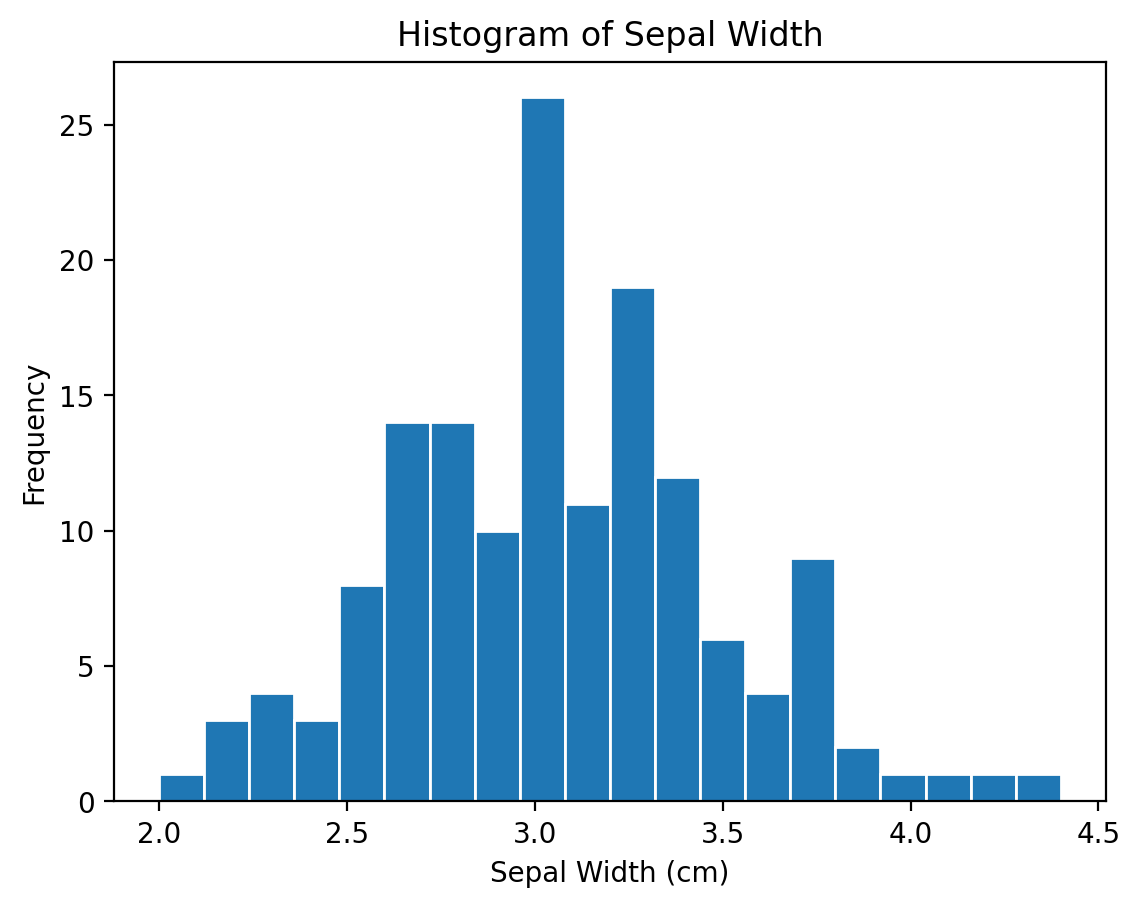

In [11]:
## YOUR SOLUTION
iris_df['sepal width (cm)'].plot.hist(bins=20, edgecolor='white', title="Histogram of Sepal Width")
plt.xlabel("Sepal Width (cm)")
plt.ylabel("Frequency")
plt.show()

# Task \#2: Simple choice prediction


The goal of this task is to get you familiar with the object structure we will use in the workshops.

## Abstract population models

For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

In [12]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    train_user_proportion = 0.6

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )

    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError

    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                for k in range(self.n_features):
                        dct[f'x{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df

    def generate_train_eval_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )

    @property
    def feature_columns(self):
        return [
            f'x{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value

## Introduction

Consider a scenario where users are presented with items, and need to decide whether or not to consume them.
We assume there is a set of users $U \subseteq \mathbb{R}^d$, and a set of items $X \subseteq \mathbb{R}^d$. When user $u\in U$ decides to consume an item $x\in X$, they gain utility $v_u(x)\in\mathbb{R}$. Note that this utility might be negative.

We assume that decisions are made according to a latent inner product utility model, such that the true utility experienced by user $u$ from consuming item $x$ is equal to the inner product:
$$v_u(x)=u^Tx$$

The `InnerProductTrueValueEnvironment` class provides a simple interface that will be useful for simulation. Here we inherit from it to implement a behvarioal model which simulates rational choice:

In [13]:
class RationalBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def _choice(self, users, items):
        """
        Simulate discrete choice.
        User take the

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, items_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, items_per_user)]
        """
        # Calculate the innner product to get the true utility u.T@v.
        # Result is a numpy array of shape (n_users, items_per_user)
        true_value = self._true_value(users, items)
        return {
            'true_value': true_value,
            'choice': true_value >= 0,
        }


As an example, here we instantiate an environment, and generate training and evaluation datasets with 1000 users. Note that the datasets are pandas DataFrames:

In [14]:
env = RationalBinaryChoiceEnvironment()
example_train_df, example_eval_df = env.generate_train_eval_datasets(n_users=1000)
example_train_df.head()

,user_id,x0,x1,x2,x3,x4,x5,x6,x7,true_value,choice
0,0,1.025959,-1.429662,-0.061695,0.119598,-0.681895,0.409998,-0.395638,-0.056903,-1.040583,False
1,0,-0.015367,-0.064281,-1.828674,1.215408,0.071429,0.736293,-0.478802,-0.431635,-1.013071,False
2,0,0.726984,0.280024,0.560321,1.114317,1.069227,-0.309899,-0.182082,-2.005171,1.036107,True
3,0,0.054061,-1.589693,1.323371,2.555185,1.687343,-0.638380,-1.722544,-0.477341,1.197435,True
4,0,-1.026938,-1.013800,-0.442134,1.525542,0.242859,-1.097831,-0.128038,0.402018,-1.262838,False


In the DataFrame above: The column `user_id` represents the user id, the columns `x_0`,...,`x_7` represent item features, the column `true_value` represents $v_u(x)$, and the column `choice` represent the actual choice (`choice==True` if $v_u(x)\ge 0$).

## Welfare

The *Welfare* associated with a predictor $f:X\to\{0,1\}$ and evaluation set $S\subseteq U \times X$ is defined according to the following formula:
$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$
where $f(x)\in\{0,1\}$ is the model prediction, and $v_u(x)$ is the true valuation of the item, as defined in the introduction above.

Implement the welfare function.

The function should receive as input a prediction function `f` (e.g. `sklearn.linear_model.LogisticRegression.fit(...).predict`), an evaluation dataset (e.g as the evaluation set returned by `env.generate_train_eval_datasets(...)`), the name of the feature columns (e.g from `env.feature_columns`), and the name of the column representing $v_u(x)$.

🔵 **Answer**:

In [33]:
def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set

    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.feature_columns`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
    ## YOUR SOLUTION
    features = eval_df[feature_columns]
    true_values = eval_df[value_column]

    predictions = f(features)

    total_welfare = (predictions * true_values).sum()
    num_rows = len(eval_df)
    welfare_value = total_welfare / num_rows
    return welfare_value


## Simulation exercise

In this exercise, we will examine the change in classification accuracy as a function of dataset size.

For each dataset size in `n_users_vec` ($\{3,6,\dots,48\}$):
* Generate training/evaluation datasets with the given amount of users (`n_users`).
* Use the training set to train two models: A Logistic Regression and a Random Forest. Both models should use the `choice` column as a binary label for training.
  (Hint: Given a training dataframe `train_df`  generated by environment `env`, the command `train_df[env.feature_columns]` returns a dataframe with features as columns).
* Evaluate the accuracy and welfare of each model in predicting choice of the evaluation set.


To reduce estimation noise, repeat the experiment 10 times for each dataset size, and average the results.

🔵 **Answer**:

In [16]:
import sklearn.linear_model
import sklearn.ensemble

n_repetitions = 10
n_users_vec = np.arange(3,50,3)
models = {
    'logistic_regression': sklearn.linear_model.LogisticRegression,
    'random_forest': sklearn.ensemble.RandomForestClassifier,
}

## YOUR SOLUTION

In [38]:
results = {
    'logistic_regression': {'accuracy': [], 'welfare': []},
    'random_forest': {'accuracy': [], 'welfare': []}
}
env = RationalBinaryChoiceEnvironment()




In [44]:
def plot_welfare_and_acc_vs_num_of_users(model_to_welfare_and_accuracy_df, model_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.subplots_adjust(wspace=0.5)
    plt.plot(model_to_welfare_and_accuracy_df[model_name].index, model_to_welfare_and_accuracy_df[model_name]['welfare'])
    plt.xlabel('Number of users')
    plt.ylabel('Welfare')
    plt.title(f'Welfare vs. Number of Users for {model_name}', fontsize=8)
    plt.subplot(1,2,2)
    plt.plot(model_to_welfare_and_accuracy_df[model_name].index, model_to_welfare_and_accuracy_df[model_name]['accuracy'])
    plt.xlabel('Number of users')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Number of Users for {model_name}', fontsize=8)
    plt.show()

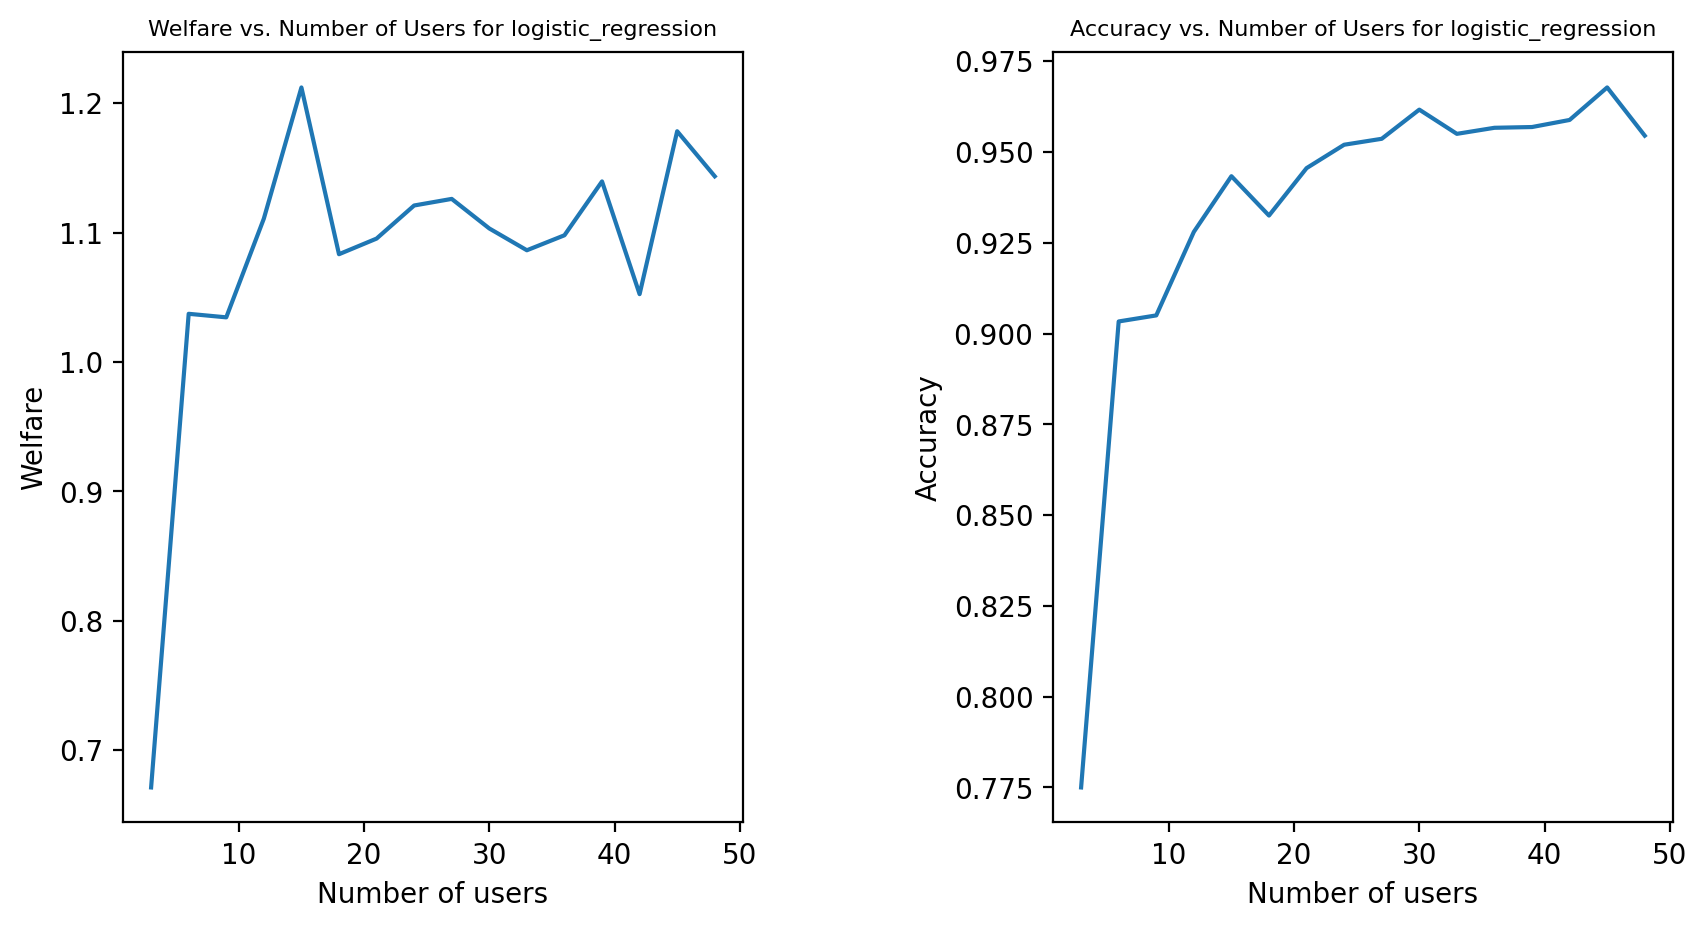

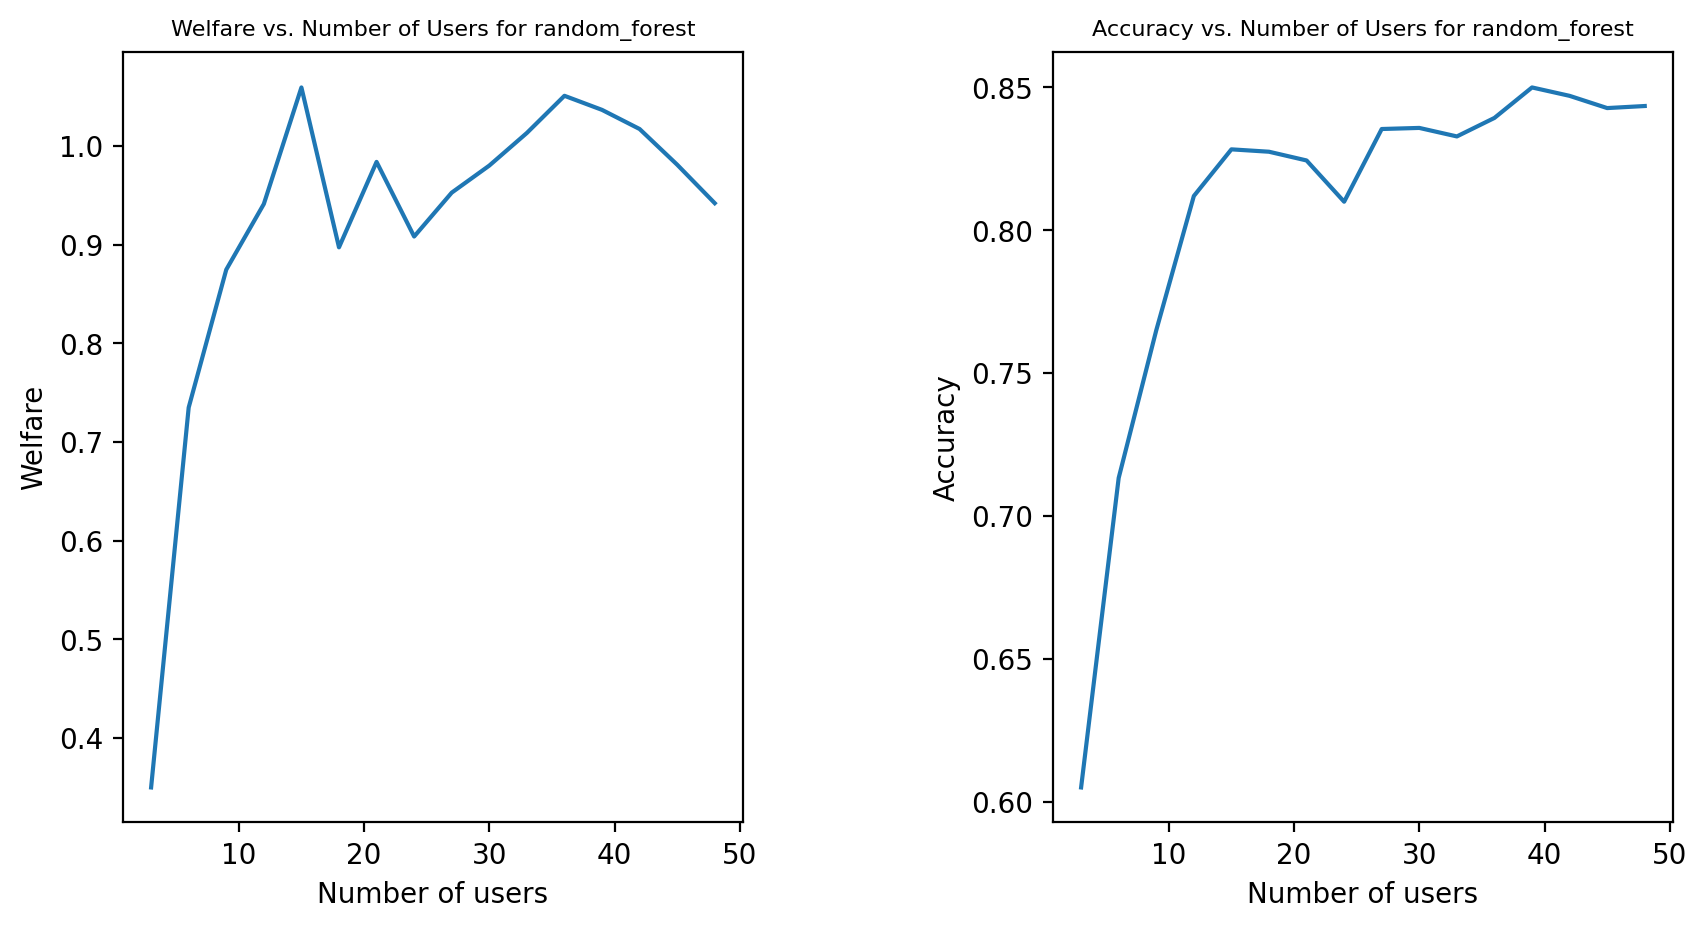

In [49]:
model_to_welfare_and_accuracy_df = { model_name: pd.DataFrame() for model_name in models.keys() }
for model_name, model in models.items():
  for n_users in n_users_vec:
      accuracies = []
      welfares = []

      for _ in range(n_repetitions):
          train_df, eval_df = env.generate_train_eval_datasets(n_users=n_users)


          X_train = train_df[env.feature_columns]
          y_train = train_df['choice']

          model_inst = model()
          model_inst.fit(X_train, y_train)

          X_eval = eval_df[env.feature_columns]
          y_eval = eval_df['choice']
          #predictions = model_inst.predict(X_eval)

          accuracy = model_inst.score(X_eval, y_eval)
          accuracies.append(accuracy)

          def prediction_function(x):
            return model_inst.predict(x)

          welfare_value = welfare(prediction_function, eval_df, env.feature_columns, "true_value")
          welfares.append(welfare_value)

      model_to_welfare_and_accuracy_df[model_name].loc[n_users, 'welfare'] = np.mean(welfares)
      model_to_welfare_and_accuracy_df[model_name].loc[n_users, 'accuracy'] = np.mean(accuracies)
  plot_welfare_and_acc_vs_num_of_users(model_to_welfare_and_accuracy_df, model_name)

Describe the results. What do you see in the graphs?

🔵 **Answer**:

(YOUR SOLUTION)

